In [37]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [38]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [39]:
import numpy as np

data_x = np.load('x_train.npy')

In [40]:
data_x

array([[[ 1.7597e+01,  8.1713e+00, -1.7842e+00, -1.9706e+01,
         -9.7135e+00, -6.1887e+01],
        [ 2.2974e-01, -5.8956e+00,  1.6837e+01,  5.0390e+00,
          2.4332e+00,  5.8914e+01],
        [-2.9654e+01, -2.1296e+01,  2.9103e+01, -4.7503e-01,
          7.5391e+01,  1.0665e+01],
        ...,
        [ 1.1982e+02,  2.1849e+02,  1.6398e+03,  5.9787e+02,
          2.1922e+03,  1.8484e+01],
        [ 9.1591e+01,  1.0378e+02,  1.8238e+03,  1.2460e+03,
          1.1301e+04,  7.5107e+02],
        [ 4.3719e+01,  3.0689e+01,  9.5092e+02,  8.5927e+02,
          8.1331e+03,  9.8883e+02]],

       [[ 2.4209e+00, -5.6039e-01,  2.3654e+01, -3.8171e+00,
          1.3721e+00,  8.2510e+00],
        [ 1.6847e+00,  2.3989e+01,  1.7803e+01, -1.9575e+01,
         -8.2534e+00, -2.3959e+01],
        [ 5.0692e-01,  5.0281e+01,  5.1196e+01,  1.6036e+01,
          7.2974e-01, -1.8185e+01],
        ...,
        [-1.5618e+01, -7.4233e+00,  3.7833e+00,  1.6565e+00,
         -1.0438e+01, -5.5229e+00],
  

In [41]:
#questa è la time series, 2429 oggetti misurati 36 volte ciascuno su 6 attributi
print(data_x.shape)

(2429, 36, 6)


In [42]:
import numpy as np

data_y = np.load('y_train.npy')
data_y

array([ 0,  0,  0, ..., 11, 11, 11])

In [43]:
#questa è l'associazione di ogni time serie alla classe
print(data_y.shape)

(2429,)


In [8]:
import torch
  
# Step 2: creating a torch tensor
t = torch.tensor(data_x)
print("Tensor before Normalize:\n", t)
  
# Step 3: Computing the mean, std and variance
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, Std and Var before Normalize:\n", 
      mean, std, var)
  
# Step 4: Normalizing the tensor
t  = (t-mean)/std
print("Tensor after Normalize:\n", t)
  
# Step 5: Again compute the mean, std and variance
# after Normalize
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, std and Var after normalize:\n", 
      mean, std, var)

Tensor before Normalize:
 tensor([[[ 1.7597e+01,  8.1713e+00, -1.7842e+00, -1.9706e+01, -9.7135e+00,
          -6.1887e+01],
         [ 2.2974e-01, -5.8956e+00,  1.6837e+01,  5.0390e+00,  2.4332e+00,
           5.8914e+01],
         [-2.9654e+01, -2.1296e+01,  2.9103e+01, -4.7503e-01,  7.5391e+01,
           1.0665e+01],
         ...,
         [ 1.1982e+02,  2.1849e+02,  1.6398e+03,  5.9787e+02,  2.1922e+03,
           1.8484e+01],
         [ 9.1591e+01,  1.0378e+02,  1.8238e+03,  1.2460e+03,  1.1301e+04,
           7.5107e+02],
         [ 4.3719e+01,  3.0689e+01,  9.5092e+02,  8.5927e+02,  8.1331e+03,
           9.8883e+02]],

        [[ 2.4209e+00, -5.6039e-01,  2.3654e+01, -3.8171e+00,  1.3721e+00,
           8.2510e+00],
         [ 1.6847e+00,  2.3989e+01,  1.7803e+01, -1.9575e+01, -8.2534e+00,
          -2.3959e+01],
         [ 5.0692e-01,  5.0281e+01,  5.1196e+01,  1.6036e+01,  7.2974e-01,
          -1.8185e+01],
         ...,
         [-1.5618e+01, -7.4233e+00,  3.7833e+00,  1.6

In [9]:
t = np.array(t)

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [60]:
Y_train = tfk.utils.to_categorical(y_train)
Y_test = tfk.utils.to_categorical(y_test)

input_shape = X_train.shape[1:]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1943, 36, 6), (1943, 12), (486, 36, 6), (486, 12))

In [61]:
input_shape = X_train.shape[1:]
classes = Y_train.shape[-1]
batch_size = 32
epochs = 200

In [62]:
def build_model(input_shape, classes, pre_model=None):
    input_layer = tfk.layers.Input(input_shape)

    conv1 = tfk.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
    conv1 = tfk.layers.BatchNormalization()(conv1)
    conv1 = tfk.layers.Dense(128, activation='relu')(conv1)
    
    conv2 = tfk.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = tfk.layers.BatchNormalization()(conv2)
    conv2 = tfk.layers.Dense(256, 'relu')(conv2)

    conv3 = tfk.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = tfk.layers.BatchNormalization()(conv3)
    conv3 = tfk.layers.Dense(128,'relu')(conv3)
    
    #conv4 = tfk.layers.Conv1D(256, kernel_size=5,padding='same')(conv3)
    #conv4 = tfk.layers.BatchNormalization()(conv4)
    #conv4 = tfk.layers.Dense(256,'relu')(conv4)
    
    gap_layer = tfk.layers.GlobalAveragePooling1D()(conv3)
    dropout = tfkl.Dropout(.2, seed=seed)(gap_layer)

    output_layer = tfk.layers.Dense(classes, activation='softmax')(gap_layer)

    model = tfk.models.Model(inputs=input_layer, outputs=output_layer)
    if pre_model is not None:
            for i in range(len(model.layers)-1):
                model.layers[i].set_weights(pre_model.layers[i].get_weights())

    model.compile(loss='categorical_crossentropy', optimizer = tfk.optimizers.Adam(),
        metrics=['accuracy'])

    return model

In [63]:
# Encoder Summary Example
model = build_model(input_shape, classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 36, 6)]           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 36, 128)           6272      
                                                                 
 batch_normalization_24 (Bat  (None, 36, 128)          512       
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 36, 128)           16512     
                                                                 
 conv1d_25 (Conv1D)          (None, 36, 256)           164096    
                                                                 
 batch_normalization_25 (Bat  (None, 36, 256)          1024      
 chNormalization)                                          

In [64]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-4)
    ]
).history

Epoch 1/200
52/52 [==============================] - 6s 51ms/step - loss: 1.9429 - accuracy: 0.3731 - val_loss: 1.8895 - val_accuracy: 0.4315 - lr: 0.0010
Epoch 2/200
52/52 [==============================] - 2s 38ms/step - loss: 1.6750 - accuracy: 0.4343 - val_loss: 1.7785 - val_accuracy: 0.4041 - lr: 0.0010
Epoch 3/200
52/52 [==============================] - 2s 37ms/step - loss: 1.6363 - accuracy: 0.4355 - val_loss: 1.7202 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 4/200
52/52 [==============================] - 2s 39ms/step - loss: 1.4728 - accuracy: 0.5015 - val_loss: 1.7690 - val_accuracy: 0.4452 - lr: 0.0010
Epoch 5/200
52/52 [==============================] - 2s 39ms/step - loss: 1.4397 - accuracy: 0.5197 - val_loss: 1.6735 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 6/200
52/52 [==============================] - 2s 36ms/step - loss: 1.3364 - accuracy: 0.5366 - val_loss: 1.7992 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 7/200
52/52 [==============================] - 2s 39ms/step - lo

Epoch 53/200
52/52 [==============================] - 2s 41ms/step - loss: 0.7706 - accuracy: 0.7408 - val_loss: 1.0567 - val_accuracy: 0.6404 - lr: 1.0000e-04
Epoch 54/200
52/52 [==============================] - 2s 43ms/step - loss: 0.7703 - accuracy: 0.7432 - val_loss: 1.0857 - val_accuracy: 0.6096 - lr: 1.0000e-04
Epoch 55/200
52/52 [==============================] - 2s 43ms/step - loss: 0.7575 - accuracy: 0.7414 - val_loss: 1.2989 - val_accuracy: 0.5925 - lr: 1.0000e-04
Epoch 56/200
52/52 [==============================] - 2s 45ms/step - loss: 0.7366 - accuracy: 0.7468 - val_loss: 1.6812 - val_accuracy: 0.5651 - lr: 1.0000e-04
Epoch 57/200
52/52 [==============================] - 2s 43ms/step - loss: 0.7578 - accuracy: 0.7293 - val_loss: 1.2422 - val_accuracy: 0.5856 - lr: 1.0000e-04
Epoch 58/200
52/52 [==============================] - 2s 41ms/step - loss: 0.7330 - accuracy: 0.7438 - val_loss: 1.1714 - val_accuracy: 0.5925 - lr: 1.0000e-04
Epoch 59/200
52/52 [====================

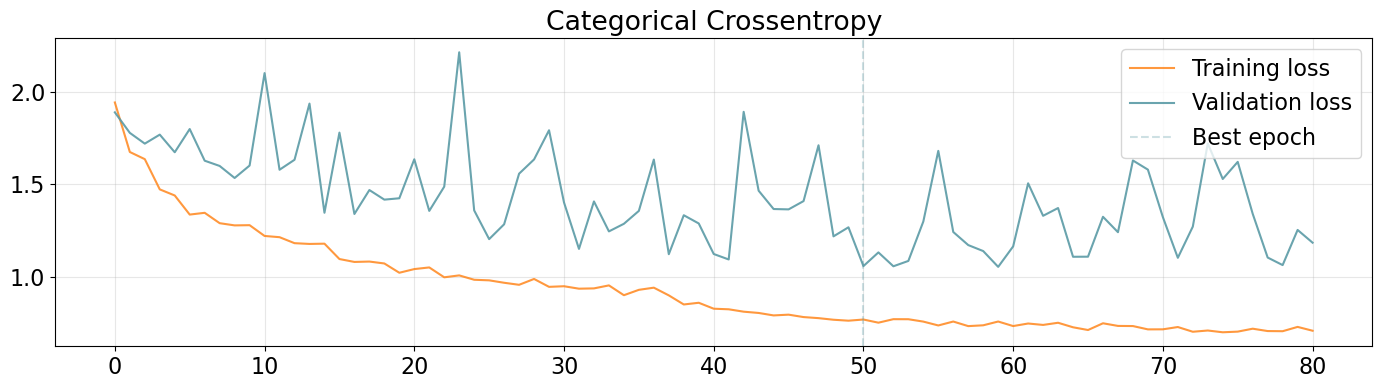

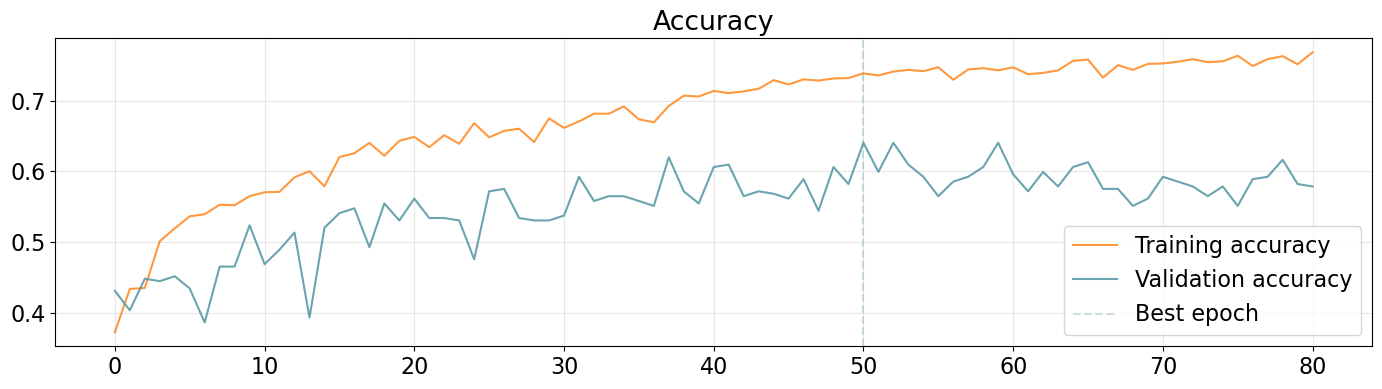

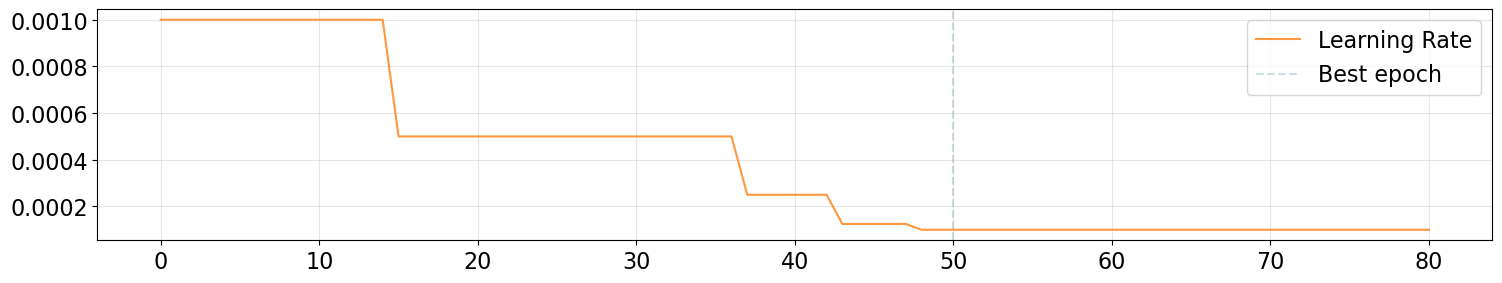

In [65]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [66]:
model.save('Handmade_17')

INFO:tensorflow:Assets written to: Handmade_17\assets


INFO:tensorflow:Assets written to: Handmade_17\assets


In [67]:
model_2 = tfk.models.load_model('Handmade_17')

In [68]:
model_2 = build_model(input_shape, classes, model_2)
model_2.summary()
tfk.utils.plot_model(model_2, expand_nested=True)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 36, 6)]           0         
                                                                 
 conv1d_27 (Conv1D)          (None, 36, 128)           6272      
                                                                 
 batch_normalization_27 (Bat  (None, 36, 128)          512       
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 36, 128)           16512     
                                                                 
 conv1d_28 (Conv1D)          (None, 36, 256)           164096    
                                                                 
 batch_normalization_28 (Bat  (None, 36, 256)          1024      
 chNormalization)                                          

In [69]:
history = model_2.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-4)
    ]
).history

Epoch 1/200
52/52 [==============================] - 21s 118ms/step - loss: 1.6307 - accuracy: 0.4852 - val_loss: 2.4427 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 2/200
52/52 [==============================] - 3s 56ms/step - loss: 1.2022 - accuracy: 0.5839 - val_loss: 1.7761 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 3/200
52/52 [==============================] - 3s 56ms/step - loss: 1.1264 - accuracy: 0.6293 - val_loss: 2.4899 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 4/200
52/52 [==============================] - 3s 57ms/step - loss: 1.1102 - accuracy: 0.6287 - val_loss: 1.3320 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 5/200
52/52 [==============================] - 3s 56ms/step - loss: 1.0335 - accuracy: 0.6572 - val_loss: 1.3886 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/200
52/52 [==============================] - 3s 51ms/step - loss: 0.9996 - accuracy: 0.6638 - val_loss: 1.5744 - val_accuracy: 0.5411 - lr: 0.0010
Epoch 7/200
52/52 [==============================] - 3s 56ms/step - 

52/52 [==============================] - 2s 30ms/step - loss: 0.6286 - accuracy: 0.7892 - val_loss: 1.1193 - val_accuracy: 0.5959 - lr: 1.0000e-04
Epoch 53/200
52/52 [==============================] - 2s 30ms/step - loss: 0.6517 - accuracy: 0.7832 - val_loss: 1.0390 - val_accuracy: 0.6541 - lr: 1.0000e-04
Epoch 54/200
52/52 [==============================] - 2s 31ms/step - loss: 0.6462 - accuracy: 0.7844 - val_loss: 1.0331 - val_accuracy: 0.6473 - lr: 1.0000e-04
Epoch 55/200
52/52 [==============================] - 2s 31ms/step - loss: 0.6358 - accuracy: 0.7838 - val_loss: 1.1765 - val_accuracy: 0.6062 - lr: 1.0000e-04
Epoch 56/200
52/52 [==============================] - 2s 31ms/step - loss: 0.6175 - accuracy: 0.7995 - val_loss: 1.3373 - val_accuracy: 0.5822 - lr: 1.0000e-04
Epoch 57/200
52/52 [==============================] - 2s 32ms/step - loss: 0.6392 - accuracy: 0.7850 - val_loss: 1.3583 - val_accuracy: 0.5651 - lr: 1.0000e-04
Epoch 58/200
52/52 [==============================] -

In [53]:
model.save('Handmade_17_tuned_NoNorm')

INFO:tensorflow:Assets written to: Handmade_16_tuned_NoNorm\assets


INFO:tensorflow:Assets written to: Handmade_16_tuned_NoNorm\assets
